# Mission

Automatisation de classification des catégories:

    1.  Réaliser une première étude de faisabilité d'un moteur de classification
        a. analyser le jeu de données en réalisant un prétraitement
        b. réduction de dimension
        c. clustering
        d. représentation graphique
  
    2. Contraintes:
        a. Deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf  
        b. une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
        c. une approche de type word/sentence embedding avec BERT ;
        d. une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).         
        e. un algorithme de type SIFT / ORB / SURF ; # Uilise les différene de contraste
        f. un algorithme de type CNN Transfer Learning.



# Librairies

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
import spacy
import tensorflow
import gensim
from wordcloud import WordCloud
import cv
import cv2
spacy.load('en_core_web_lg')
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


# Fonctions

In [77]:
import time
from sklearn.decomposition import PCA
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, cat, pca = False, TSNE_Ncomponent = 2) :
    if TSNE_Ncomponent < 4:
        method = "barnes_hut"
    else:
        method = "exact"
    # ACP avant pour plus de stabilité
    if pca:
        try: 
            pca = PCA(n_components = features.shape[1])
            features = pca.fit_transform(features) 
        except:
            import sklearn
            svd = sklearn.decomposition.TruncatedSVD(n_components = features.shape[1] )
            features =svd.fit_transform(features)
            
    l_cat = list(set(cat))
    y_cat_num = [(1-l_cat.index(cat[i])) for i in range(len(cat))]
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components= TSNE_Ncomponent, perplexity=30, n_iter=2000, 
                                 init='pca', learning_rate=200, random_state=42, method=method) # 
    X_tsne = tsne.fit_transform(features) 
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    TSNE_visu_fct(X_tsne, y_cat_num, cls.labels_, ARI, l_cat)
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation par clusters')
    
    plt.show()
    print("ARI : ", ARI)
    
from collections import Counter
def keyWords(text, nonTag = "", word = ""):
    """keyWords _summary_ Tokeanization with word cleaning and word pos extraction

    _extended_summary_

    Args:
        text (_type_): _description_ 
        tag (_type_): _description_
        nonTag (str, optional): _description_. Defaults to "".
        word (str, optional): _description_. Defaults to "".

    Returns:
        _type_: _description_
    """
    import spacy
    nlp = spacy.load("en_core_web_sm")
    nlp.max_length = len(text)
    doc = nlp(text)
    # all tokens that arent stop words or punctuations
    words = [token.lemma_.lower()
             for token in doc
             if (not token.is_stop and
                 not token.is_punct and
                 not token.pos_ in nonTag and
                 not token.text in word)]
    
    return words

def wordsFr(text, N):
    from collections import Counter
    word_freq = Counter(text)
    common_words = word_freq.most_common(N)
    return common_words


# Analyse de texte

## Récupération du dataset

In [78]:
path = 'data/flipkart_com-ecommerce_sample_1050.csv' # à adapter = répertoire de stockage du dataset
data = pd.read_csv(path)
print(data.shape)

(1050, 15)


## Prépapration des données

### Fréquences des mots de toutes les descriptions

In [79]:
allWords = ""
for a in range(data.shape[0]):
   allWords =  allWords + data.description[0]

In [80]:
words = keyWords(allWords, nonTag=["SYM", "ADJ", "NUM"], word= ["cm", "Price", "Abstract"])

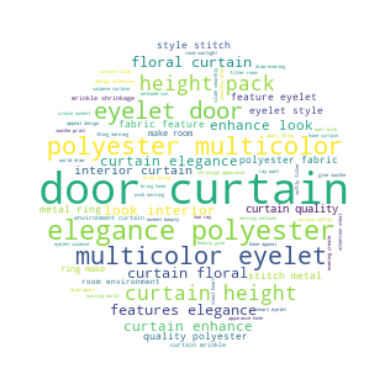

In [81]:
# lower max_font_size
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(max_font_size=40, background_color="white",mask=mask).generate(" ".join(words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Nettoyage du texte

In [82]:
nlp = spacy.load("en_core_web_lg")
des = []
desVector = []
# Pour chaque descriptions
for a in range(data.shape[0]):
    doc = nlp(data.description[a]) # Tokenisation
    words = ""
    
    vector = doc.vector
    desVector.append(vector)
     
    # Pour chaque mots
    for token in doc:
        if (not token.is_stop and # s'il n'est pas un stop word
            not token.is_punct and # s'il n'est pas une ponctuation !!!! Pas parfait
            not token.is_space and # s'il n'est pas un espace
            not token.pos_ in "SYM" and # s'il n'est pas un symbole
            not token.pos_ in "NUM" and # s'il n'est pas un nombre
            not token.text in ["cm", "Price"]): # s'il ne contient pas "cm", "Price", ","
                words = words + " " + token.lemma_ # Lemmatisation 
    words = words.replace("\r", "").replace("\n", "").replace("\t", "").replace(",", "")
    words = words.lower() # tous en minuscules    
    des.append(words)
   
des[0:10]

[' key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack rs curtain enhance look interior curtain high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant- wrinkle anti shrinkage elegant apparance home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart thing morning welcome bright sun ray want wish good morning world draw close evening create special moment joyous beauty give soothe print bring home elegant curtain softly filter light room right sunlight specifications elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance design door type eyelet model abstract polyester door curtain set model id duster25 color multicolor dimension length box number content sales package pack sales package curtains body des

In [83]:
desVector[0:2]

[array([-2.159673  , -0.52004886, -1.3874271 ,  1.1297698 ,  3.7554603 ,
        -0.20037523,  1.4150352 ,  2.7998264 , -1.0833738 , -0.51964766,
         5.1549973 ,  0.9094536 , -3.797203  ,  1.0884337 ,  1.5638695 ,
         0.4825205 ,  0.560438  ,  0.4725907 , -1.0474406 , -1.6422561 ,
         0.05224874,  0.24484675, -0.34689662,  0.5945994 , -0.47773004,
        -0.85548455, -2.129377  , -1.0258733 , -1.1817228 ,  0.6374917 ,
         0.8370236 , -0.9051601 ,  0.34992823, -1.6338024 , -2.0419621 ,
        -0.68810564,  0.2918087 ,  1.5991793 ,  1.1883324 ,  0.69716835,
         1.1968936 ,  0.14705513, -0.7657442 ,  0.31786352, -2.542816  ,
         1.8950559 ,  0.59319705, -0.16735552,  0.38973802, -0.60676455,
        -0.5630801 ,  1.4017495 , -0.709783  , -2.8192568 , -0.6209136 ,
         1.4341156 , -1.0620908 ,  0.7786268 ,  1.099616  , -0.9835683 ,
        -0.26567507, -0.8025939 , -0.3856504 , -0.91360694,  1.4631689 ,
         1.1916317 , -2.5236619 , -3.0442286 ,  1.2

In [84]:
data["des"] = des

### Extraction des catégories d'objets

In [85]:
data.product_category_tree

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

In [86]:
cat = []
for a in range(data.shape[0]):
    tmp = data.loc[a, "product_category_tree"].split(">>")
    t = tmp[0].replace("]", "").replace("[", "").replace('''"''', "")
    cat.append(t)

data["cat"] = cat
data.cat.unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

## BOW & Tf-idf

<AxesSubplot: >

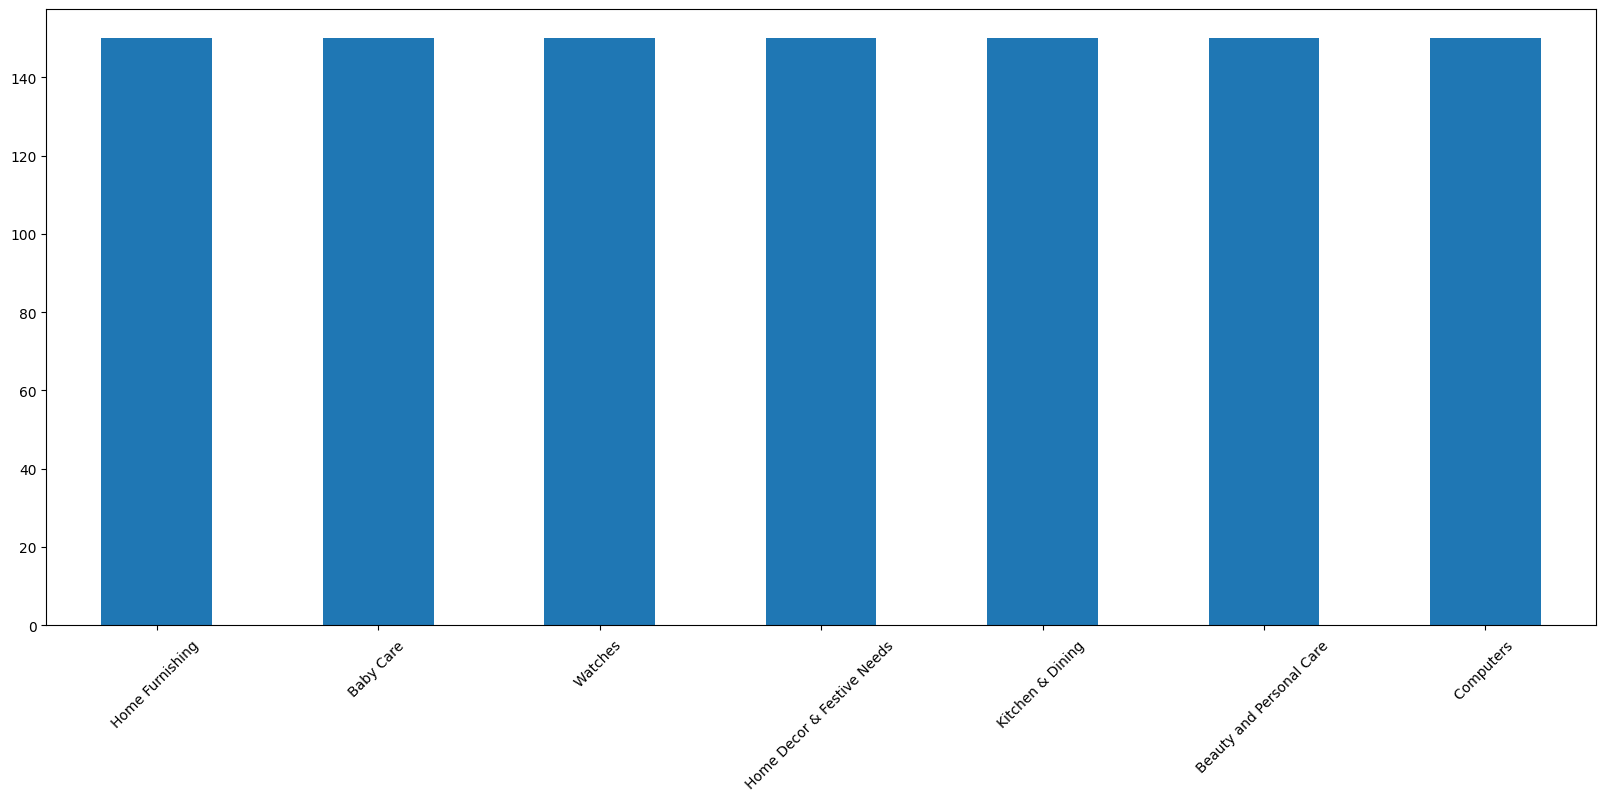

In [87]:
df = data.loc[:,["cat", "des", "description"]]
backup = data
df.cat.value_counts().plot.bar(rot = 45, figsize=(20, 8))

In [88]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
df = data.loc[:,["cat", "des", "description"]]
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1) 

cv_fit = cvect.fit(df.des)
ctf_fit = ctf.fit(df.des)

cv_transform = cvect.transform(df.des)  
ctf_transform = ctf.transform(df.des)  

CountVectorizer : 
-----------------
ARI :  0.385 time :  9.0


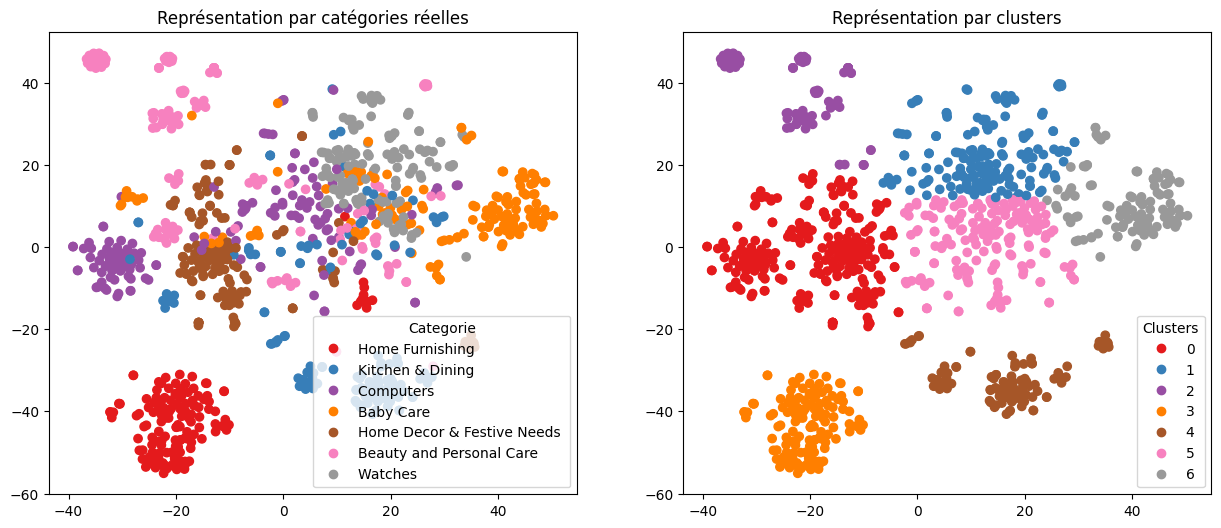

ARI :  0.385
Tf-idf : 
--------
ARI :  0.5219 time :  8.0


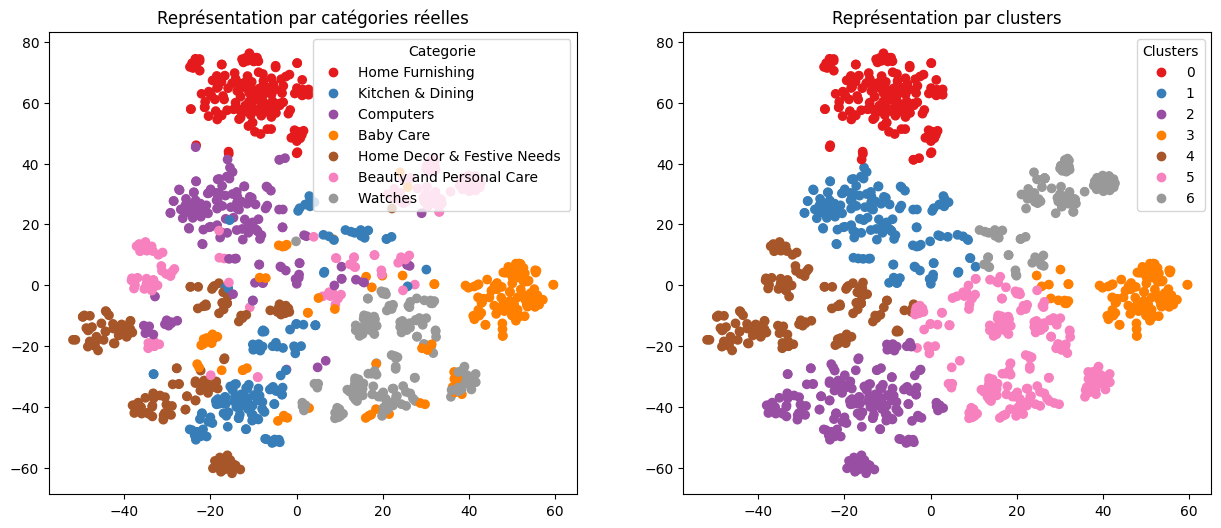

ARI :  0.5219


In [89]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform, df.cat, pca = True)

print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform, df.cat, pca = True)

## Word2Vec

In [90]:
import tensorflow

In [91]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

### Création du modèle Word2Vec

In [92]:
w2v_size=300 #Dimensionality of the word vectors
w2v_window=10 # Maximum distance between the current and predicted word within a sentence.
w2v_min_count=2 #  Ignores all words with total frequency lower than this 
w2v_epochs=100 # Number of iterations (epochs) over the corpus
maxlen = 24 # adapt to length of sentences
sentences = data.description.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [93]:
# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=5)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences) # Build vocabulary
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs) # train model
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 3692
Word2Vec trained


In [94]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 5193


### Création de la matrice d'embedding

In [95]:
# Création de la matrice d'embedding
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.7111
Embedding matrix: (5193, 300)


### Création du modèle d'embedding

In [96]:
# Création du modèle
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 24, 300)           1557900   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,557,900
Trainable params: 1,557,900
Non-trainable params: 0
_________________________________________________________________



### Exécution du modèle

In [97]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 300)

ARI :  0.1982 time :  8.0


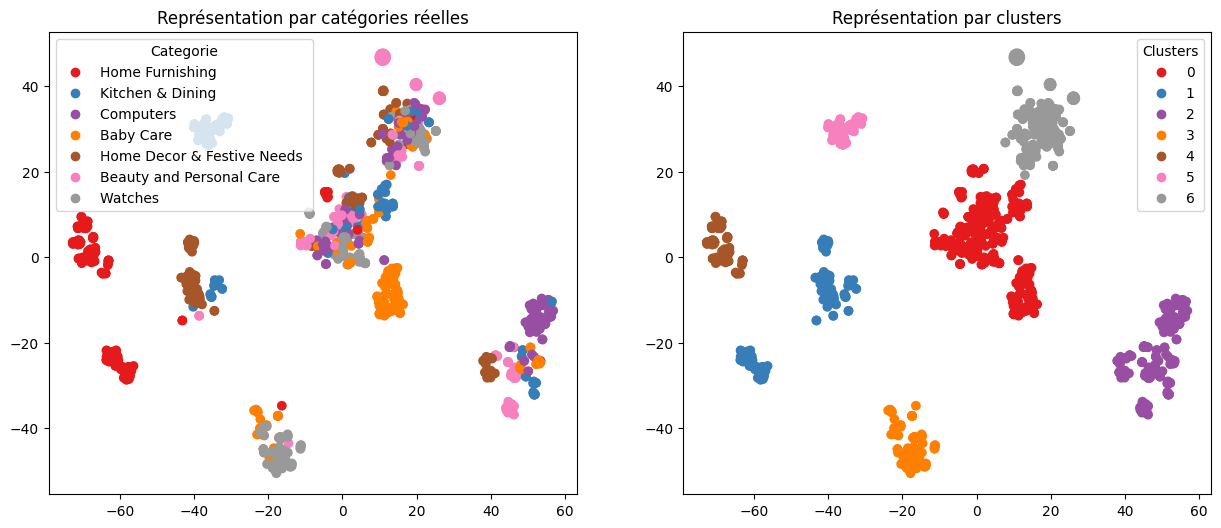

ARI :  0.1982


In [98]:
ARI, X_tsne, labels = ARI_fct(embeddings, df.cat, pca = True) # n_components > perplexity

## BERT

In [99]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
from transformers import*

os.environ["TF_KERAS"]='1'

In [100]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.1
2.10.1
Num GPUs Available:  1
True


### Fonctions communes

In [101]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

### BERT hub Tensorflow

In [105]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [106]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer
sentences = df['description'].to_list()
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  20.0


ARI :  0.3159 time :  8.0


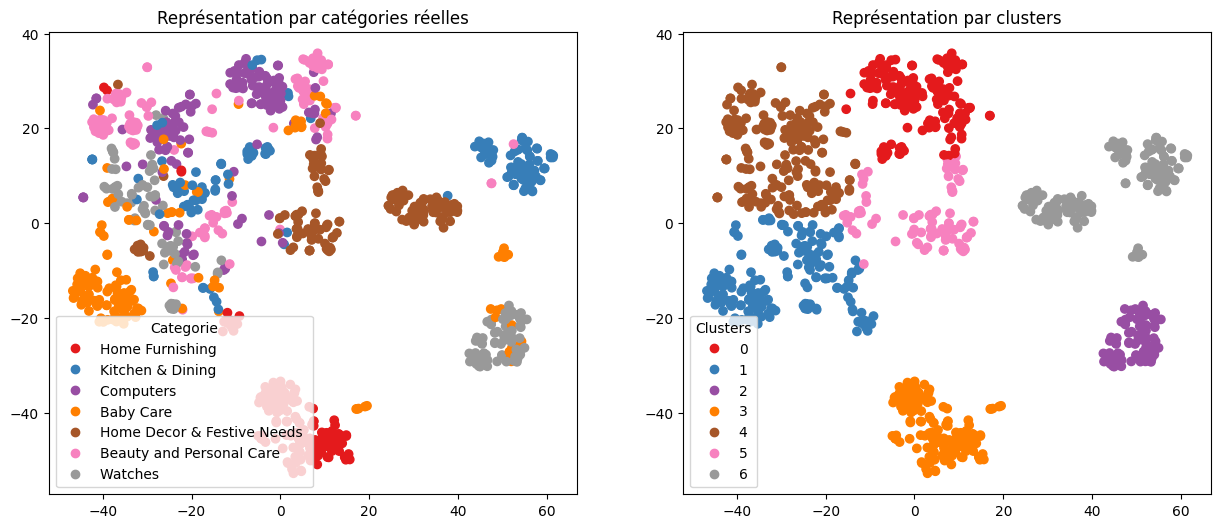

ARI :  0.3159


In [107]:
ARI, X_tsne, labels = ARI_fct(features_bert, df.cat)

## USE - Universal Sentence Encoder

In [108]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [109]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.1
2.10.1
Num GPUs Available:  1
True


In [110]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [111]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [112]:
batch_size = 10
sentences = df['des'].to_list()

In [113]:
features_USE = feature_USE_fct(sentences, batch_size)

ARI :  0.4148 time :  8.0


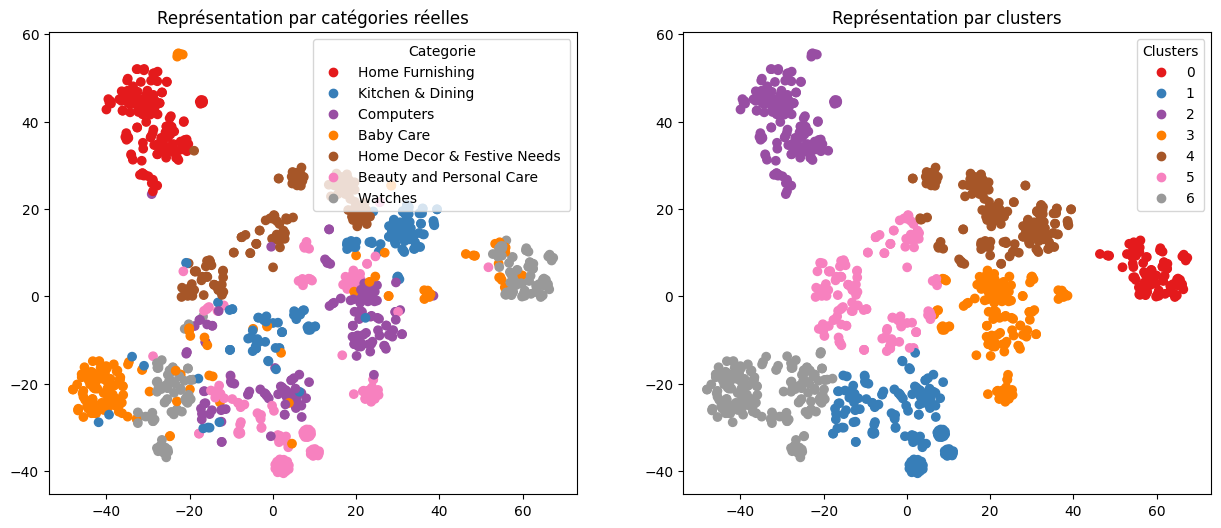

ARI :  0.4148


In [114]:
ARI, X_tsne, labels = ARI_fct(features_USE, df.cat)

# Analyse d'images

## Importation des images

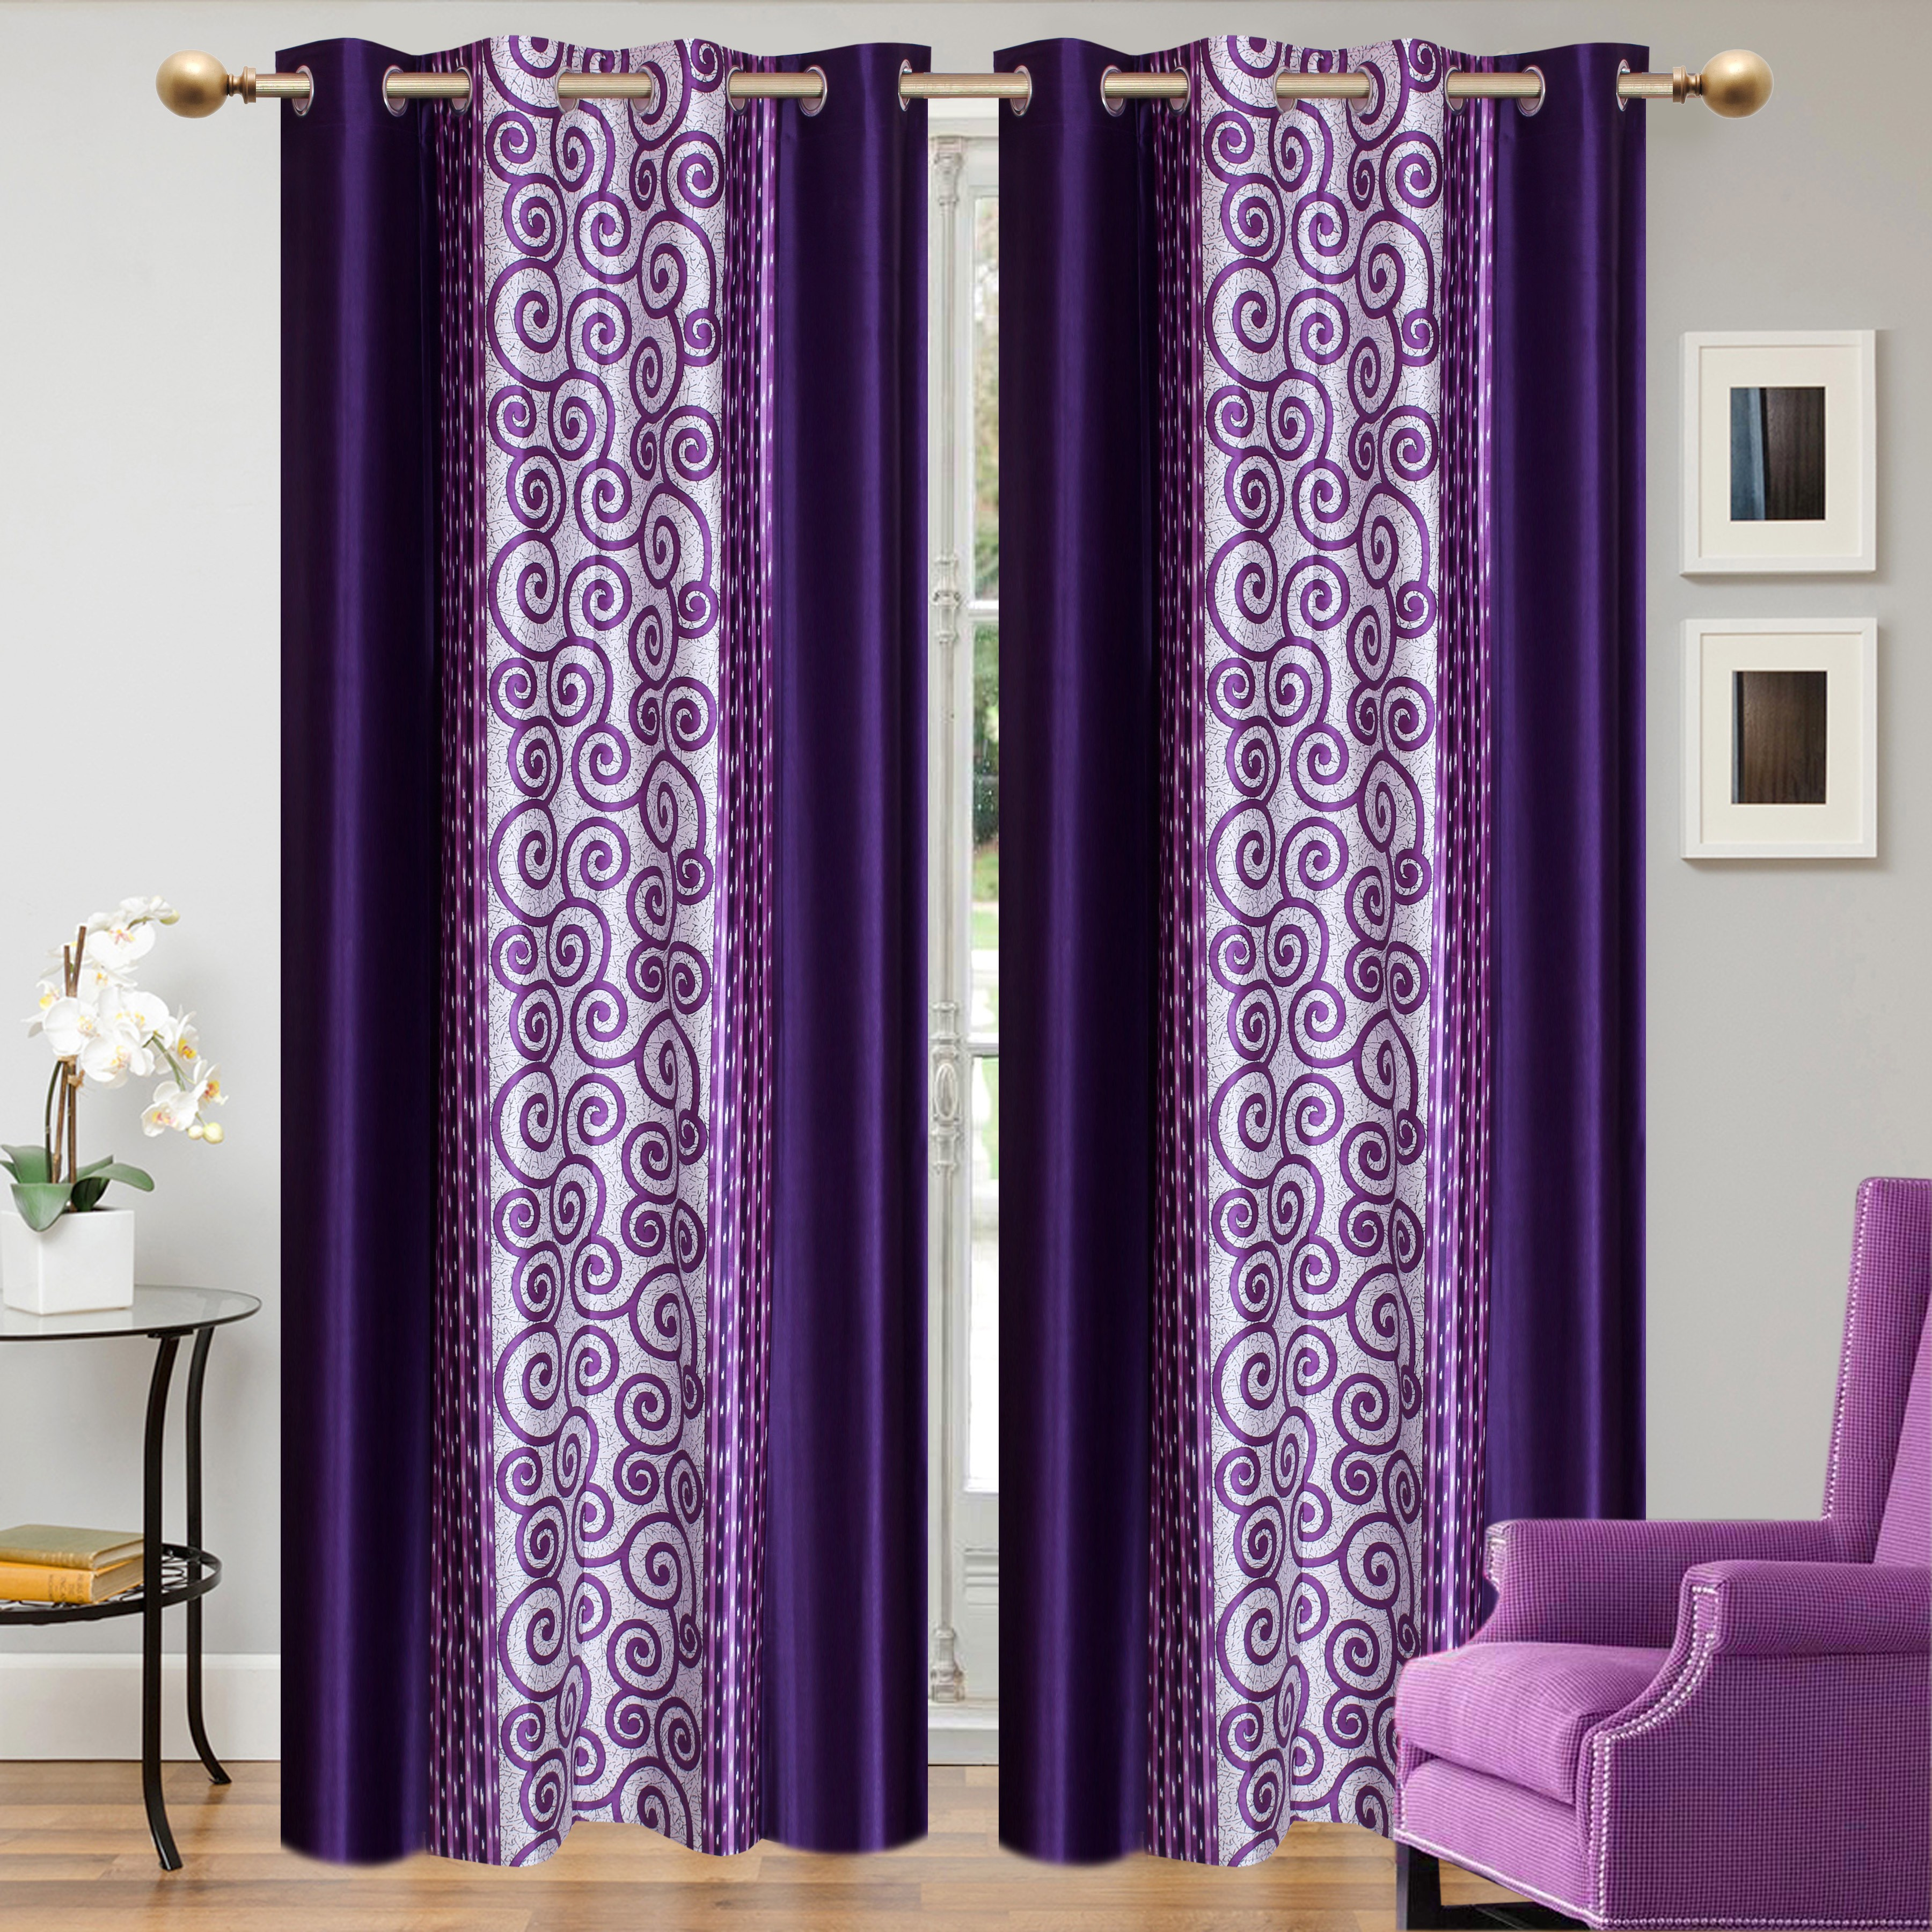

In [115]:
from IPython.display import Image
data2 = backup
data2 = data2.sort_values("image")
data2.image = data2.image.apply(lambda x: 'data/Images/'+str(x))
Image(data2.image[0], width=150)

In [116]:
from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL
def redim(array_im, width, height):
    '''Redimensionne l\'image correspondant à array_im dans la largeur et la hauteur définie'''
    min_x = 100000
    max_x = 0
    min_y = 100000
    max_y = 0
    shape = array_im.shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]
    im = cv2.resize(array_im, dsize=(width,height))
    del shape
    return im

def preprocess(image, path=False):
    '''prétraitement des images:
    * filtre gaussian
    * égalisation de l'histogramme
    * redimensionnement
    prend un entrée le chemin vers l'image et en sortie la matrice np.array de l'image traitée
    '''
    #ouverture du fichier
    if path == False: #si on a fourni un array en entree :
        im = image
    else: #si on a fourni un chemin vers le fichier en entree:
        im = np.array(Image_PIL.open(image))
    
    #greyscale
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    #flou gaussien
    im = gaussian_filter(im, sigma=2)
    
    #égalisation
    im = cv2.equalizeHist(im)
    
    return redim(im, 128, 128)

## SIFT
Ressources :    https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

                https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/

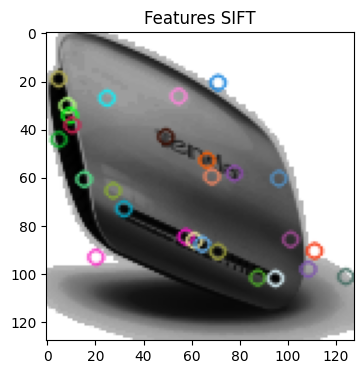

In [117]:
import cv2 #opencv pour SIFT
sift = cv2.SIFT_create()
img_sift = preprocess(data2.iloc[12]['image'], path=True)
keypoints, descriptors = sift.detectAndCompute(img_sift,None)
img=cv2.drawKeypoints(img_sift,keypoints,img_sift)

plt.figure(figsize=(4,4))
plt.title('Features SIFT')
plt.imshow(img)

In [119]:
liste_keypoints = []
liste_descripteurs = []
imageID = []

for row in range(data2.shape[0]):
    img_sift = preprocess(data2.iloc[row]['image'], path=True)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_sift,None)
    liste_descripteurs.append(descriptors)
    liste_keypoints.append(keypoints)
    imageID.append([row] * descriptors.shape[0])

c:\Users\SSosa\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [120]:
liste_descripteurs = pd.DataFrame(np.concatenate(liste_descripteurs))
imageID = np.concatenate(imageID)# Information de l'image au quel appartient le descripteur

In [121]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100, random_state=0, n_init="auto").fit(liste_descripteurs)

In [126]:
bovw = np.zeros(shape=(data2.shape[0], np.unique(kmeans.labels_).shape[0]), dtype='object') # Empty bag of visual words

In [131]:
kmeans.labels_[0]
for a in range(kmeans.labels_.shape[0]):
    bovw[imageID[a],kmeans.labels_[a]] = 1

ARI :  -0.0007 time :  10.0


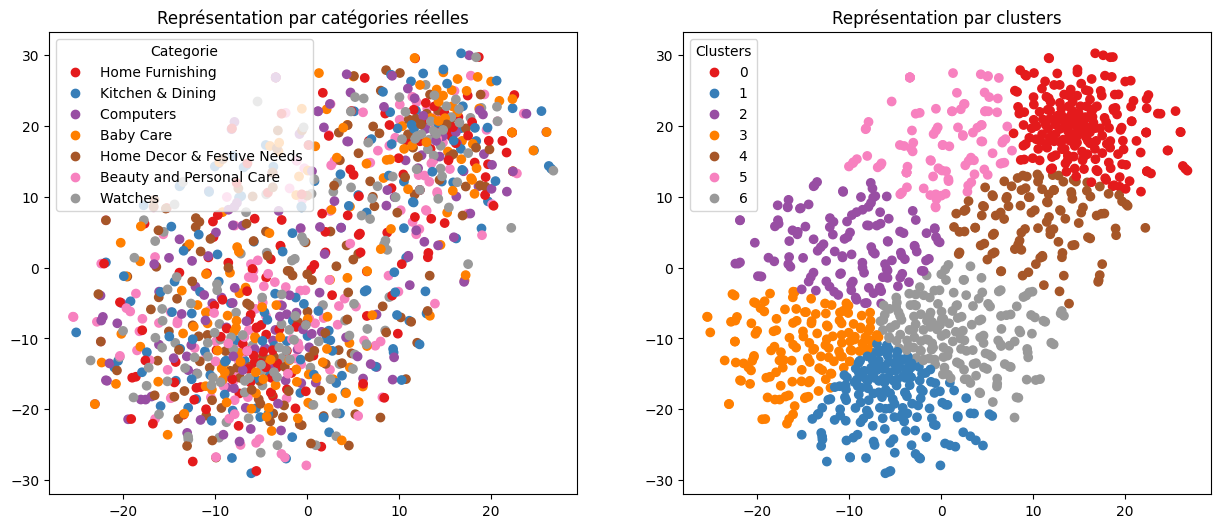

ARI :  -0.0007


In [132]:
ARI, X_tsne, labels = ARI_fct(bovw, df.cat)

## ORB

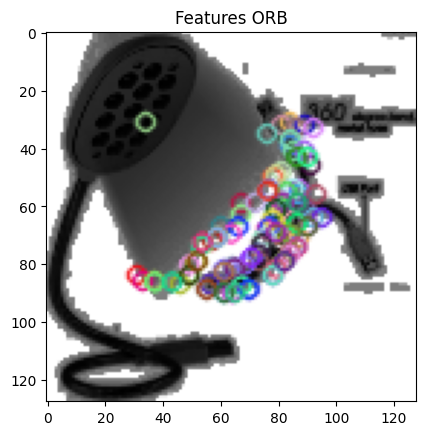

In [ ]:
orb = cv2.ORB_create()
#find keypoints and descriptors
kp, des = orb.detectAndCompute(img_sift, mask = None)
#draw only keypoints location, not size and orientation:
image_orb = cv2.drawKeypoints(img_sift, kp, outImage = True, flags=2)
plt.title('Features ORB')
plt.imshow(image_orb)
plt.show()

##  Surf

## Utilisation du VGG-16 pré-entraîné (non supervisé)
### Importation et preprocess_input

(1050, 15)
Found 1050 files belonging to 1 classes.
33/33 - 67s - 67s/epoch - 2s/step
ARI :  0.3087 time :  12.0


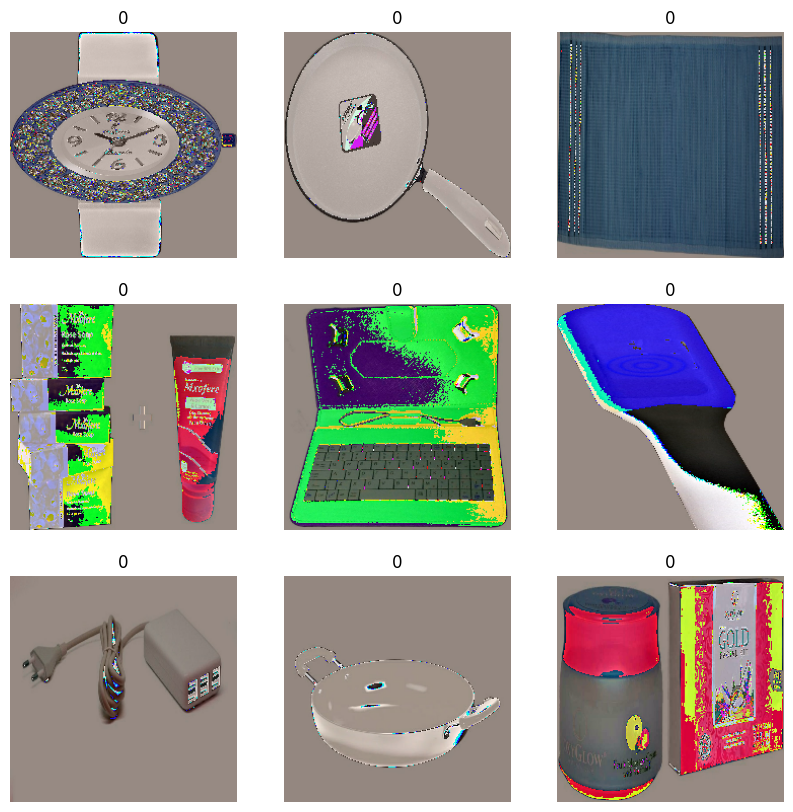

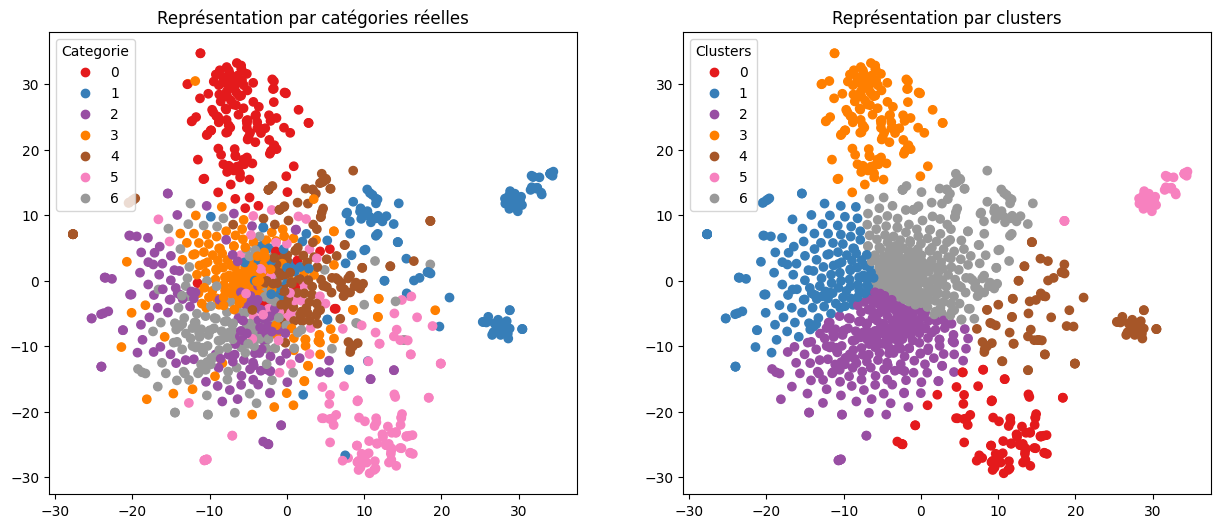

ARI :  0.3087


In [ ]:
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import manifold, decomposition
from  keras.applications.vgg16 import VGG16
from sklearn import cluster, metrics
path = 'data/flipkart_com-ecommerce_sample_1050.csv' 
data = pd.read_csv(path)
print(data.shape)

cat = []
for a in range(data.shape[0]):
    tmp = data.loc[a, "product_category_tree"].split(">>")
    t = tmp[0].replace("]", "").replace("[", "").replace('''"''', "")
    cat.append(t)

data["cat"] = cat

from IPython.display import Image
data = data.sort_values("image")
data.image = data.image.apply(lambda x: 'data/Images/'+str(x))

model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
labels = pd.Categorical(data.cat).codes.tolist()
data2 = tf.keras.utils.image_dataset_from_directory('data', image_size=(224,224),shuffle= False,
                                                    labels=labels, label_mode = "categorical") 
data2 = data2.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x),y))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in data2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

model_info = model.predict(data2, batch_size=10, verbose=2)
ARI, X_tsne, labels = ARI_fct(model_info.reshape(1050, -1), pd.Categorical(data.cat).codes.tolist())

# Combinaison des features text et images

In [ ]:
im = model_info.reshape(1050, -1)
mixt = np.concatenate([ctf_transform.toarray(), im], axis = 1)

ARI :  0.3256 time :  13.0


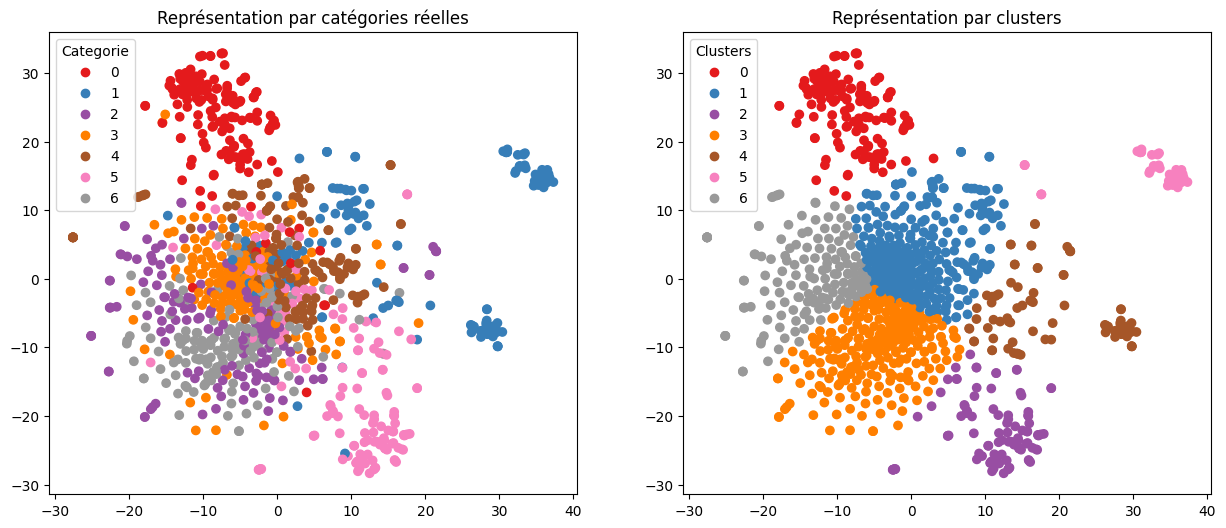

ARI :  0.3256


In [ ]:
ARI, X_tsne, labels = ARI_fct(mixt, pd.Categorical(data.cat).codes.tolist())

# Bonus: Utilisation du VGG-16 pré-entraîné (supervisé)

In [ ]:
data3 = tf.keras.utils.image_dataset_from_directory('data', image_size=(224,224), 
                                                    labels=  pd.Categorical(data.cat).codes.tolist(), label_mode = "int",
                                                    seed = 10, validation_split = 0.1, shuffle = True, subset = "both") 

Found 1050 files belonging to 1 classes.
Using 945 files for training.
Using 105 files for validation.


In [ ]:
data3[0]

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
pd.Categorical(data.cat).categories.values.tolist()

['Baby Care ',
 'Beauty and Personal Care ',
 'Computers ',
 'Home Decor & Festive Needs ',
 'Home Furnishing ',
 'Kitchen & Dining ',
 'Watches ']

In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

batch_size = 32
img_size = (224, 224)

# Load the pre-trained VGG16 model
vgg = vgg16.VGG16(weights='imagenet', include_top=False, 
                  input_shape=(img_size[0], img_size[1], 3))

# Freeze all layers in the base model
for layer in vgg.layers:
    layer.trainable = False
    
# Add a new classifier layer for the 7 classes
x = Flatten()(vgg.output)
x = Dense(7, activation='softmax')(x)

# Define the new model
model = Model(inputs=vgg.input, outputs=x)

# Compile the model

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(data3[0], epochs=10, validation_data=data3[1],
                    callbacks=[early_stopping])

Epoch 1/10
30/30 [==============================] - 56s 2s/step - loss: 15.5419 - accuracy: 0.6698 - val_loss: 7.9844 - val_accuracy: 0.8476
Epoch 2/10
30/30 [==============================] - 41s 1s/step - loss: 2.0406 - accuracy: 0.9302 - val_loss: 12.9851 - val_accuracy: 0.8095
Epoch 3/10
30/30 [==============================] - 52s 2s/step - loss: 0.9062 - accuracy: 0.9608 - val_loss: 9.2454 - val_accuracy: 0.8190
Epoch 4/10
30/30 [==============================] - 57s 2s/step - loss: 0.2949 - accuracy: 0.9841 - val_loss: 9.2630 - val_accuracy: 0.8190


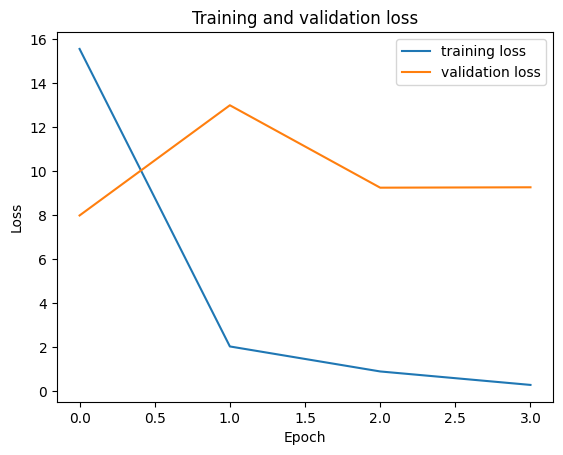

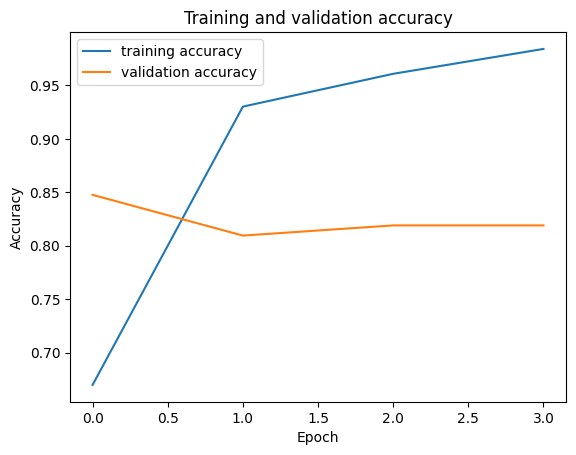

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
y_true = np.concatenate([y for x, y in data3[1]], axis=0)
y_pred = model.predict(data3[1]).argmax(axis=-1)

4/4 [==============================] - 1s 224ms/step


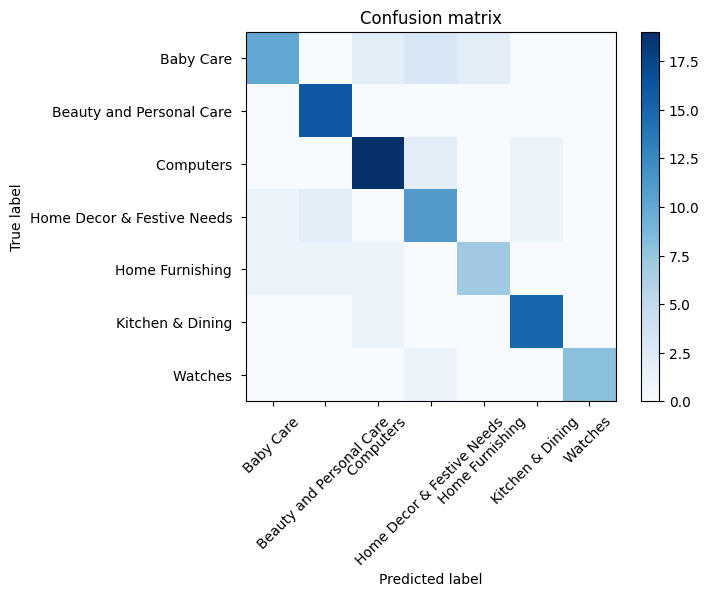

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
class_names = pd.Categorical(data.cat).categories.values.tolist()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()